# Previsao em Serie Temporal

Faremos umas brincadeiras de previsao (forecasting) utilizando uma serie temporal (time series) de consumo de energia eletrica.

Dataset utilizado: Open Power System Data ([OPSD](https://open-power-system-data.org/)).  Este dataset contem dados diarios de: consumo de energia eletrica; producao de energia eolica; producao de energia solar. De 2006 a 2017.

Vamos considerar apenas o consumo de energia eletrica. Discutiremos a razao disto.

Este eh um exemplo bem simples de analise de series temporais. No final do notebook eu deixo varios apontadores de artigos (de blogs) focados na pratica (na implementacao), para quem quiser se aprofundar no tema.

## Imports

In [17]:
import requests
from io import StringIO

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Carga dos Dados

### Setup do acesso ao Drive

In [18]:
orig_url='https://drive.google.com/file/d/1fZAUBMt94Q4zEEpkgwNgcM4JbKt1gaGG/view?usp=sharing'
file_id = orig_url.split('/')[-2]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
url = requests.get(dwn_url).text
csv_raw = StringIO(url)

#### Leitura da base e ajuste do index

In [19]:
df = pd.read_csv(csv_raw, sep=",", index_col=0)
df.index = pd.to_datetime(df.index)

## Algumas Visualizacoes

#### Histograma do consumo

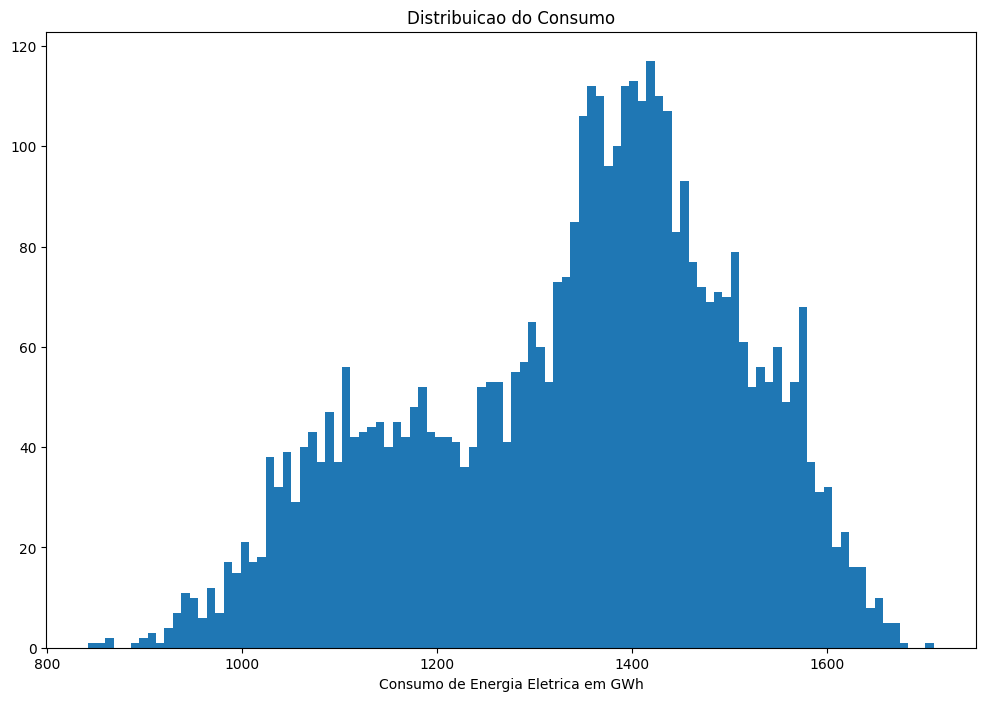

In [20]:
plt.figure(figsize=(12,8))
plt.hist(df['Consumption'], bins=100)
plt.title("Distribuicao do Consumo")
plt.xlabel("Consumo de Energia Eletrica em GWh")
plt.show()

#### Consumo ao longo do tempo

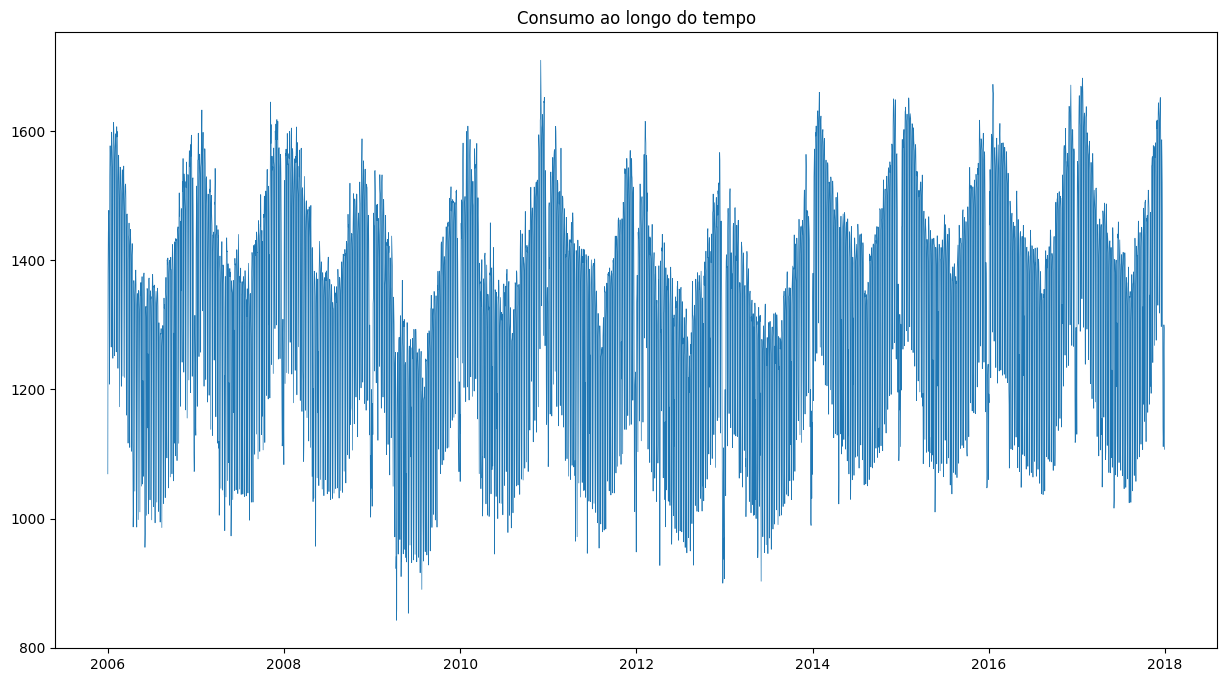

In [21]:
plt.figure(figsize=(15,8))
plt.plot(df['Consumption'], linewidth = 0.5)
plt.title("Consumo ao longo do tempo")
plt.show()

#### Consumo ao longo do tempo (outra forma)

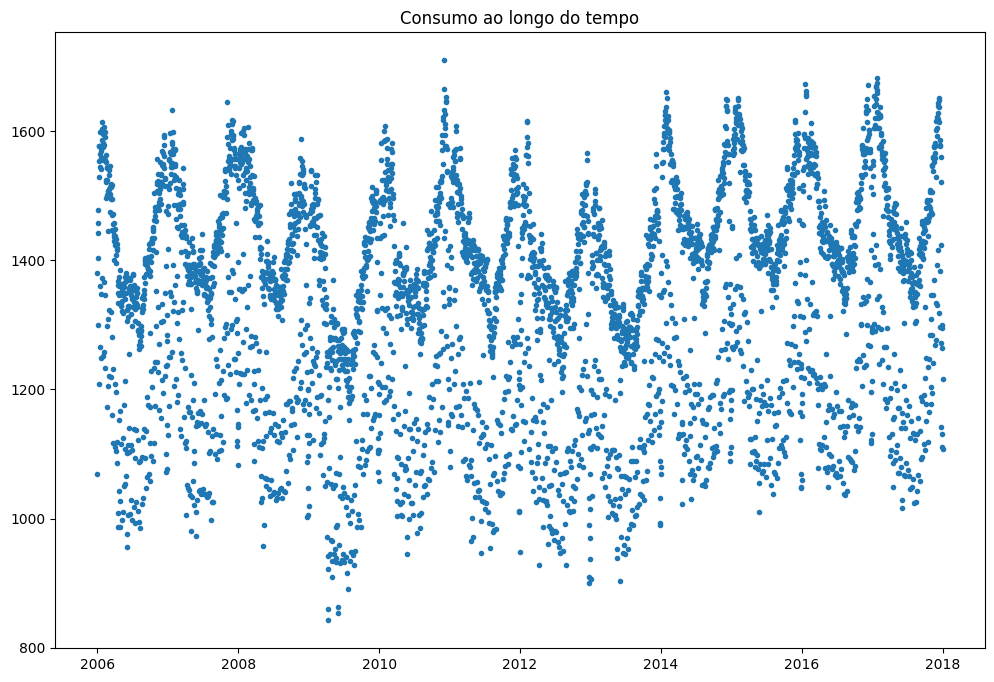

In [22]:
plt.figure(figsize=(12,8))
plt.plot(df['Consumption'], linewidth = 0.5, linestyle = "None", marker='.')
plt.title("Consumo ao longo do tempo")
plt.show()

#### Consumo ao longo do tempo (filtrando um periodo)


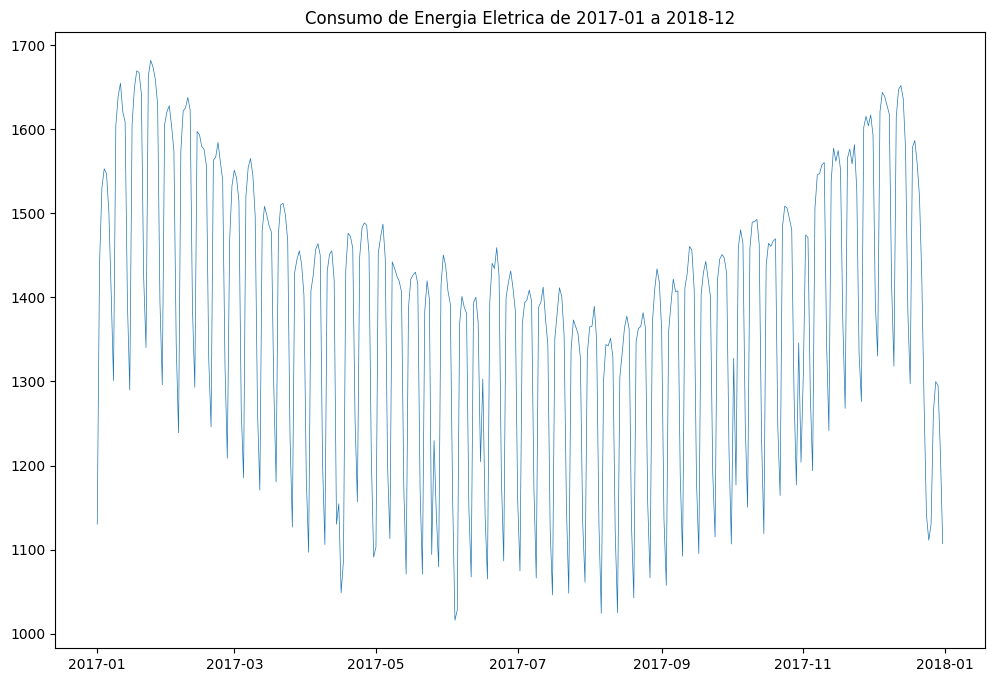

In [23]:
begin = '2017-01'
end = '2018-12'
plt.figure(figsize=(12,8))
plt.plot(df.loc[begin:end]['Consumption'], linewidth = 0.5)
plt.title("Consumo de Energia Eletrica de %s a %s" % (begin, end))
plt.show()


#### Boxplots do consumo por ano, mes, dia

In [24]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day

import seaborn as sns

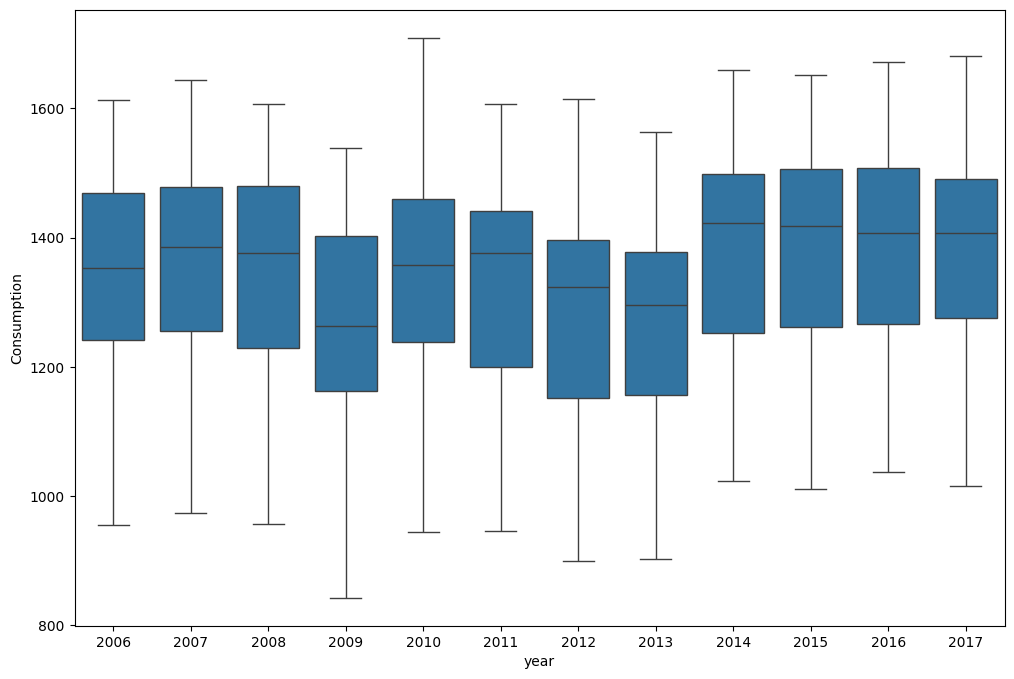

In [25]:
# por ano
plt.figure(figsize=(12,8))
sns.boxplot(data=df, x=df['year'], y='Consumption')
plt.show()

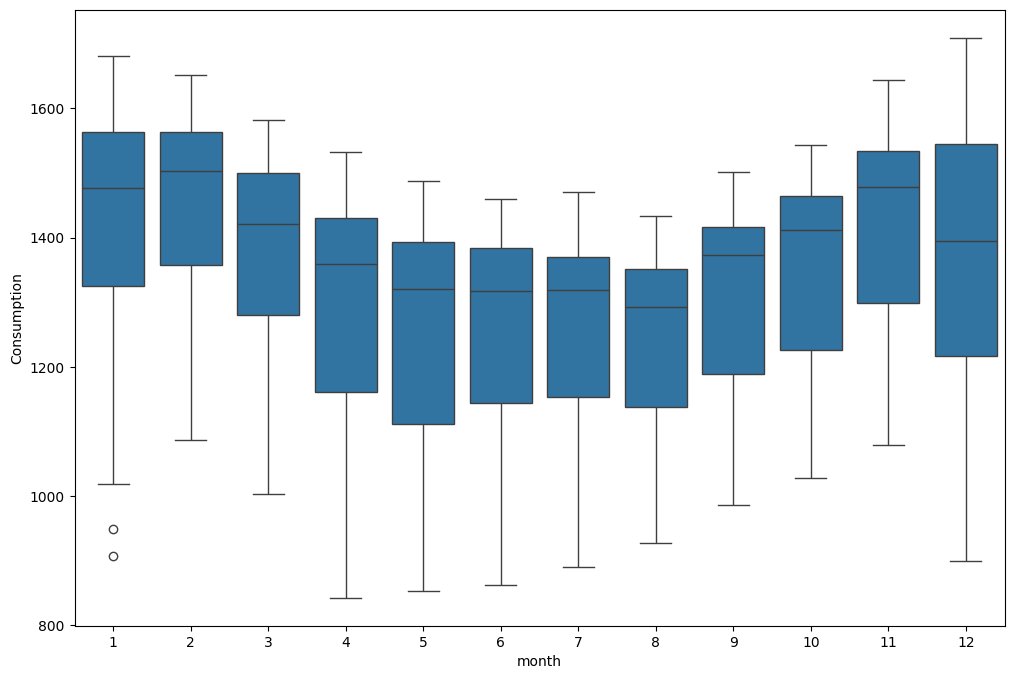

In [26]:
# por mes
plt.figure(figsize=(12,8))
sns.boxplot(data=df, x=df['month'], y='Consumption')
plt.show()

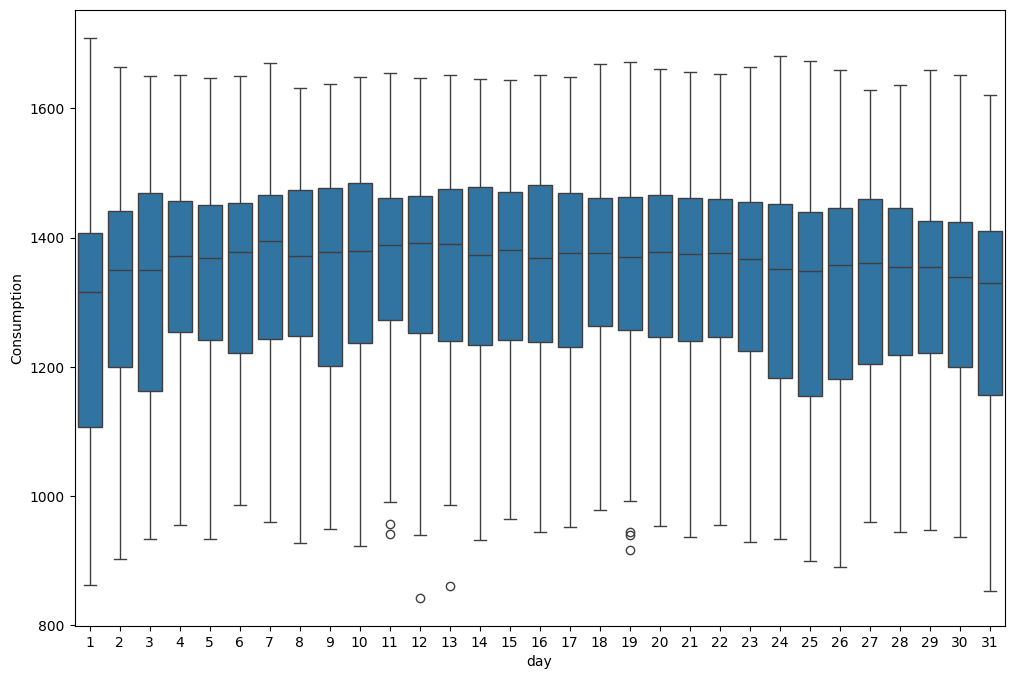

In [27]:
# por dia
plt.figure(figsize=(12,8))
sns.boxplot(data=df, x=df['day'], y='Consumption')
plt.show()

## Gerando um novo dataframe com foco no consumo


In [28]:
df_consumption = df[['Consumption']].copy() # novo df com a coluna consumption

df_consumption.loc[:,'Day1'] = df_consumption.loc[:,'Consumption'].shift() # nova coluna com os valores do dia anterior
df_consumption.loc[:,'DiffDay1'] = df_consumption.loc[:,'Day1'].diff() # nova coluna com a diferenca entre o dia anterior e o dia antes do anterior

# generalizar
for i in range(2,20):
  df_consumption.loc[:,f'Day{i}'] = df_consumption.loc[:,'Consumption'].shift()
  df_consumption.loc[:,f'DiffDay{i}'] = df_consumption.loc[:,f'Day{i}'].diff()

df_consumption = df_consumption.dropna() # removendo NA
df_consumption.head()

,Consumption,Day1,DiffDay1,Day2,DiffDay2,Day3,DiffDay3,Day4,DiffDay4,Day5,...,Day15,DiffDay15,Day16,DiffDay16,Day17,DiffDay17,Day18,DiffDay18,Day19,DiffDay19
Date,,,,,,,,,,,,,,,,,,,,,
2006-01-03,1442.533,1380.521,311.337,1380.521,311.337,1380.521,311.337,1380.521,311.337,1380.521,...,1380.521,311.337,1380.521,311.337,1380.521,311.337,1380.521,311.337,1380.521,311.337
2006-01-04,1457.217,1442.533,62.012,1442.533,62.012,1442.533,62.012,1442.533,62.012,1442.533,...,1442.533,62.012,1442.533,62.012,1442.533,62.012,1442.533,62.012,1442.533,62.012
2006-01-05,1477.131,1457.217,14.684,1457.217,14.684,1457.217,14.684,1457.217,14.684,1457.217,...,1457.217,14.684,1457.217,14.684,1457.217,14.684,1457.217,14.684,1457.217,14.684
2006-01-06,1403.427,1477.131,19.914,1477.131,19.914,1477.131,19.914,1477.131,19.914,1477.131,...,1477.131,19.914,1477.131,19.914,1477.131,19.914,1477.131,19.914,1477.131,19.914
2006-01-07,1300.287,1403.427,-73.704,1403.427,-73.704,1403.427,-73.704,1403.427,-73.704,1403.427,...,1403.427,-73.704,1403.427,-73.704,1403.427,-73.704,1403.427,-73.704,1403.427,-73.704


## Separando treino e teste

In [29]:
X_train = df_consumption[:'2016'].drop(['Consumption'], axis = 1)
y_train = df_consumption.loc[:'2016', 'Consumption']
X_test = df_consumption[:'2017'].drop(['Consumption'], axis = 1)
y_test = df_consumption.loc[:'2017', 'Consumption']

## Geracao e Avaliacao dos Modelos

## Imports

Uma novidade

In [30]:
from sklearn.model_selection import TimeSeriesSplit

Outros imports

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

Gerando e avaliando os modelos


LR: 0.343747 (0.029773)
Lasso: 0.343748 (0.029770)
Ridge: 0.343747 (0.029773)
Poly: 0.429947 (0.075069)
KNN: 0.646307 (0.083185)
RF: 0.614845 (0.092034)


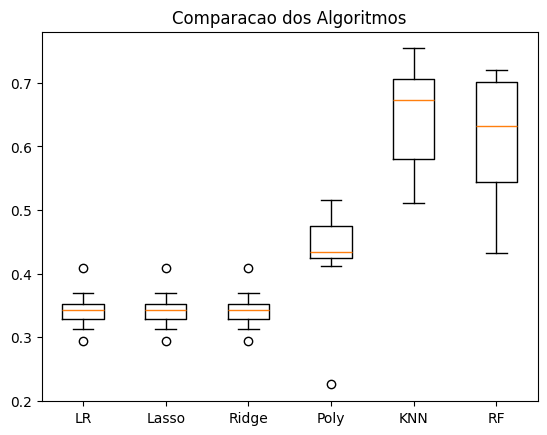

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge

models = []

models.append(('LR', LinearRegression()))
models.append(('Lasso', Lasso()))
models.append(('Ridge', Ridge()))

Input=[('polyfeatures', PolynomialFeatures(degree=2)), ('regmodel', LinearRegression())]
pipe = Pipeline(Input)
models.append(('Poly', pipe))

models.append(('KNN', KNeighborsRegressor()))
models.append(('RF', RandomForestRegressor(n_estimators = 10)))

results = []
names = []
for name, model in models: # Validacao Cruzada
  tscv = TimeSeriesSplit(n_splits=10)
  cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
  results.append(cv_results)
  names.append(name)
  print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

# Comparacao Visual dos Algoritmos
plt.boxplot(results, tick_labels=names)
plt.title('Comparacao dos Algoritmos')
plt.show()